In [1]:
import numpy as np
import numpy.ma as ma
import pickle
import os
from astropy.table import Table
import multiprocess as mp
import tqdm

from matplotlib import pyplot as plt
import matplotlib.colors as colors
from scipy.ndimage import gaussian_filter1d
import matplotlib as mpl

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

cmap = plt.get_cmap('cividis')
div_cmap = truncate_colormap(cmap, 0.2,0.8)
up_cmap = truncate_colormap(cmap, 0.5,1.0)

# Data Loading

In [2]:
pzchat = np.load('../outputs/p_z_chat/BFD.npy')
pzchat_weights = np.load('../outputs/p_z_chat/BFD_weights.npy')

std = np.load('../outputs/p_z_chat/BFD_std.npy')
med = np.load('../outputs/p_z_chat/BFD_meds.npy')
avg = np.load('../outputs/p_z_chat/BFD_avg.npy')

redshifts = np.load('../outputs/p_z_chat/redshifts.npy')

wideres = 32

In [3]:
with open('../../big_processing/ng_per_wc.pkl', 'rb') as f:
    ngals_per_cell = pickle.load(f)
ng = np.sum(ngals_per_cell)
"%i galaxies"%ng

'207984658 galaxies'

In [4]:
np.save('../outputs/final_binned_data/ngals_per_cell', ngals_per_cell)

# Functions

In [5]:
def concentration(boundary_z, pzchats):
    diffs = np.abs(redshifts-boundary_z)
    boundary_idx = np.where(diffs==min(diffs))[0][0]
    perc_above_bound = [np.sum(pzchati[boundary_idx:])/len(pzchati) for pzchati in pzchats]
    
    return perc_above_bound

In [6]:
def concentration_range(center, width, pzchats):
    
    lower_z = center-width
    lower_dists = np.abs(redshifts-lower_z)
    lower_idx = np.where(lower_dists==min(lower_dists))[0][0]
    
    higher_z = center+width
    higher_dists = np.abs(redshifts-higher_z)
    higher_idx = np.where(higher_dists==min(higher_dists))[0][0]
    
    perc_within = [np.sum(pzci[lower_idx:higher_idx], axis=0) for pzci in pzchats]
    
    return np.array(perc_within)

In [7]:
def get_overlap(pzb):
    nz_all_overlap = np.einsum('mz,nz->mn', pzb, pzb)
    nz_all_overlap_var = np.einsum('m,n->mn', np.sqrt(np.diag(nz_all_overlap)), np.sqrt(np.diag(nz_all_overlap)))
    nz_all_overlap /= nz_all_overlap_var
            
    return nz_all_overlap    

# No Trash

In [8]:
nbins = 4
binned_wc = [[]] ; current_total = 0

ordered_meds = sorted(med)
ordered_wcs = [wc for _, wc in sorted(zip(med, range(wideres**2)))]
for m,wc in zip(ordered_meds,ordered_wcs):
    current_total += ngals_per_cell[wc]
    binned_wc[-1] += [wc]
    if current_total//(ng/nbins) == len(binned_wc):
        binned_wc += [[]]
        
binned_wc.pop()

[]

In [9]:
binned_data = np.zeros(wideres**2)
for i,mask in enumerate(binned_wc):
    binned_data[mask] = i

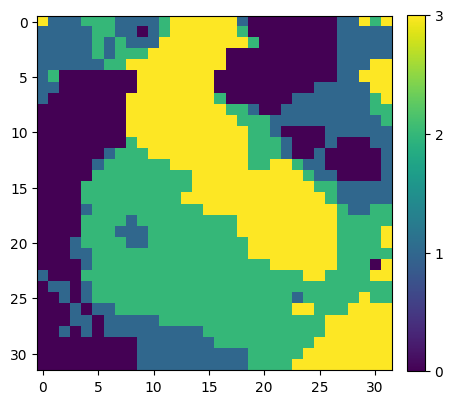

In [10]:
plt.imshow(binned_data.reshape((wideres,wideres)))
plt.gcf().set_size_inches(5,5)
plt.colorbar(ticks=[0,1,2,3,4], fraction=0.046, pad=0.04)
plt.show()

In [11]:
with open('../outputs/final_binned_data/wide_bins.pkl', 'wb') as f:
    pickle.dump(binned_data, f)

In [12]:
p_z_bhat = [np.sum(pzchat[idcs],axis=0)/len(idcs) for idcs in binned_wc]

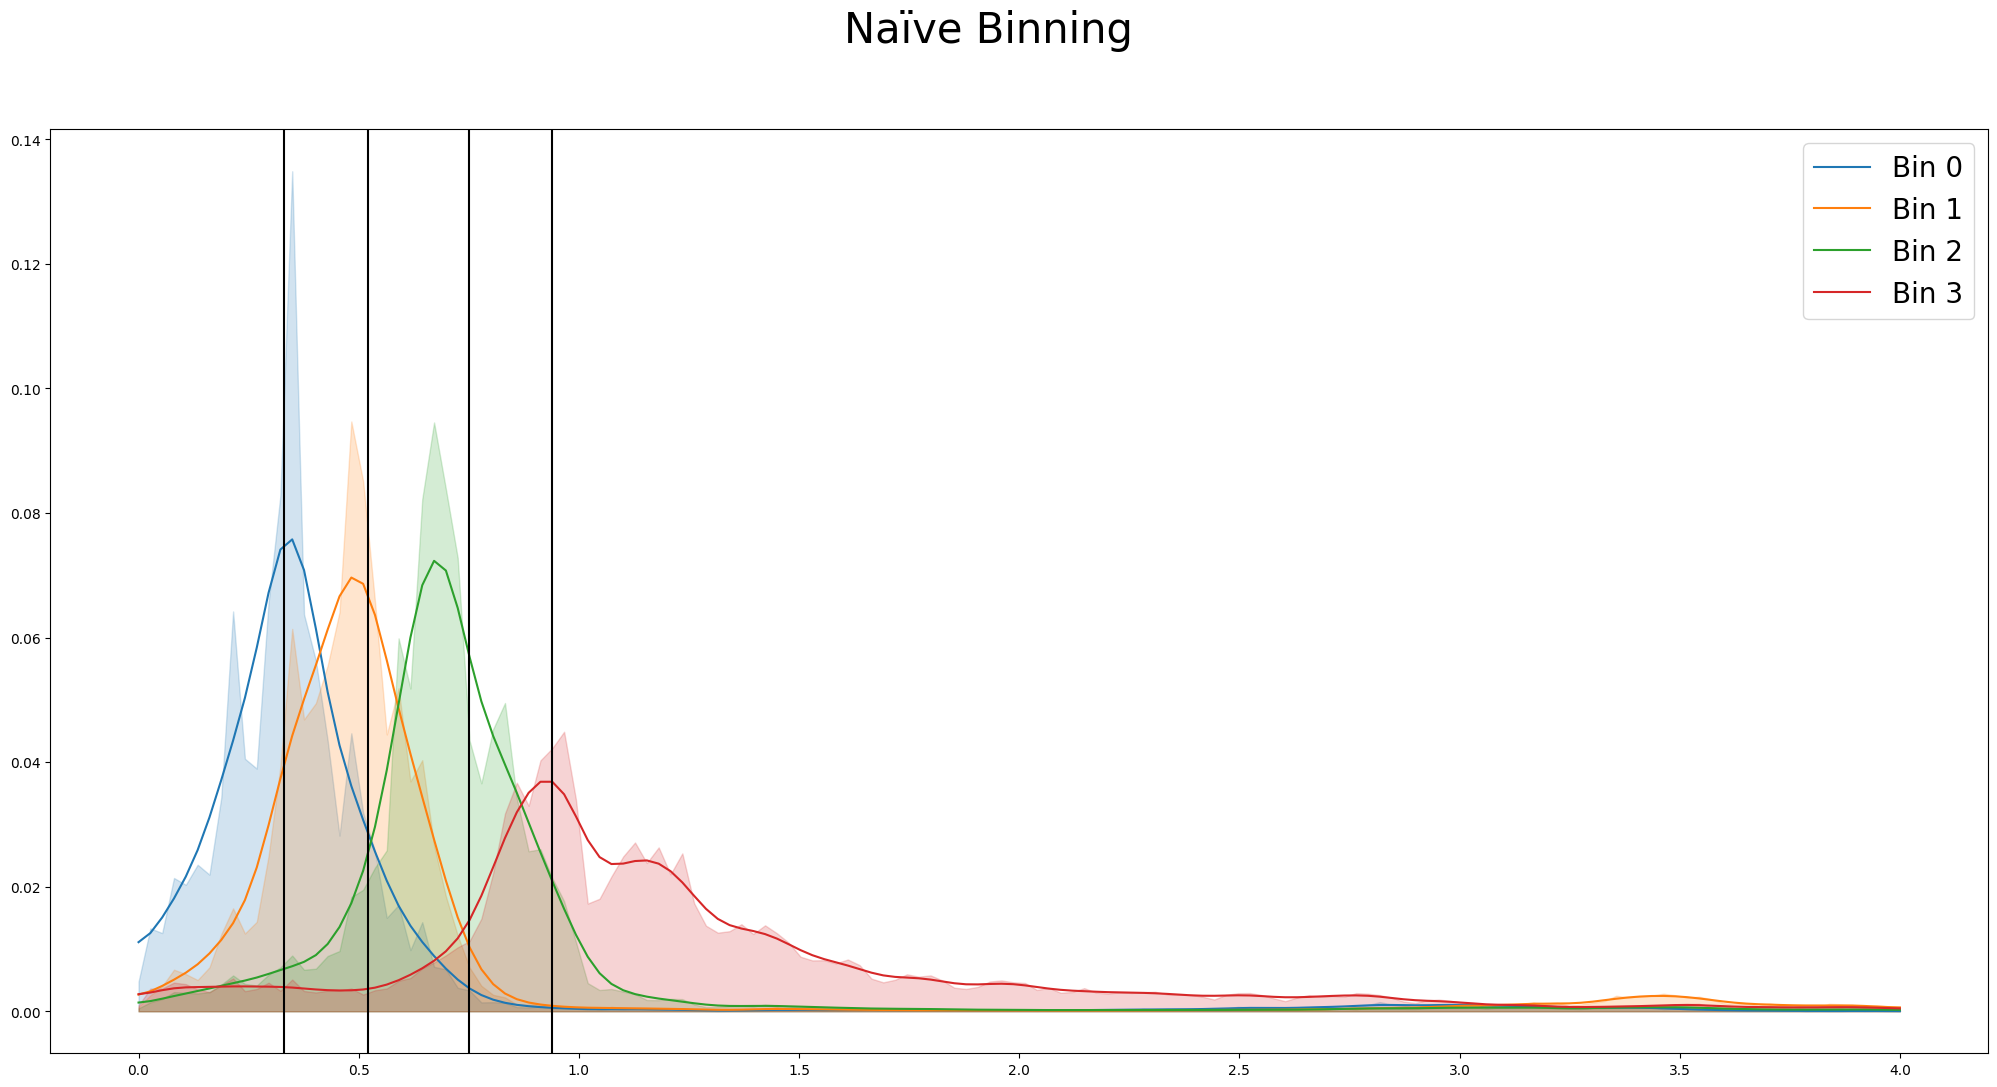

In [13]:
colors = [plt.cm.tab20(i*2) for i in range(5)]

fig, ax = plt.subplots(1, figsize=(25,12))
r = (0,3)
for i,pz in enumerate(p_z_bhat):
    ax.plot(redshifts, gaussian_filter1d(pz, 2), color=colors[i], label="Bin %i"%i)
    ax.fill_between(redshifts, pz, alpha=0.2, color=colors[i])


y3_means = [0.33, 0.52, 0.75, 0.94]
for m in y3_means:
    ax.axvline(m, color='black')

plt.suptitle("Naïve Binning", fontsize=30)
        
ax.legend(fontsize=20, loc='upper right')
plt.show()

In [14]:
def conc(j, boundary_z, pzchats, a):
    diffs = np.abs(redshifts-boundary_z)
    boundary_idx = np.where(diffs==min(diffs))[0][0]
    perc_above_bound = [np.sum(pzchati[boundary_idx:])/len(pzchati) for pzchati in pzchats]

    a.hist(perc_above_bound, 30, label="z = %.03f"%boundary_z, histtype='step', color=cs[j])

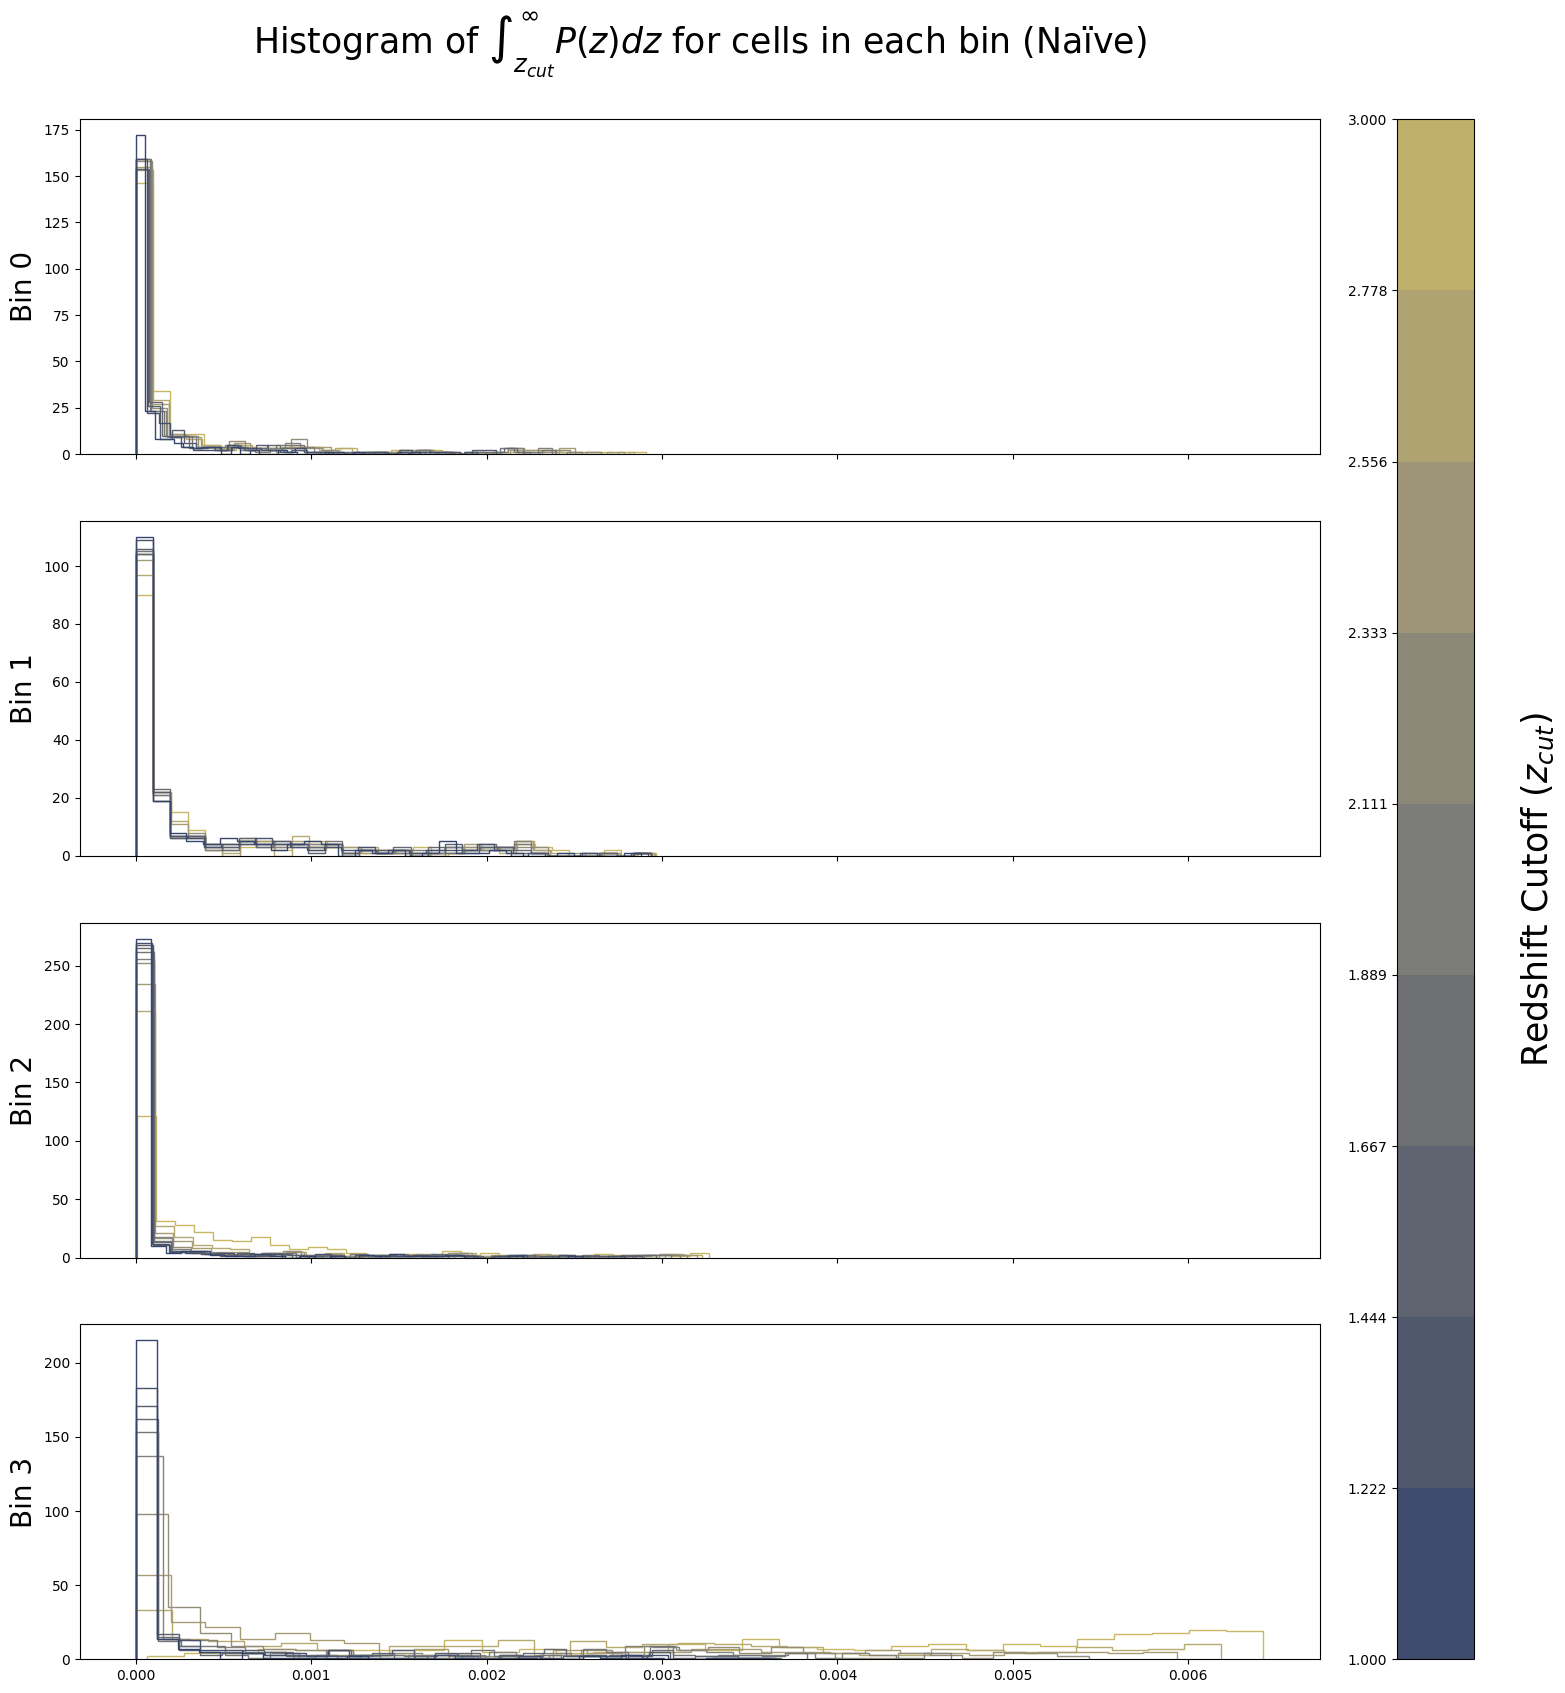

In [15]:
fig, axs = plt.subplots(4, figsize=(20,20), sharex=True)

N = 10
try_z = np.linspace(1,3,N)
cs = div_cmap(np.linspace(1,0,N))
   
for i,b in enumerate(binned_wc):
    [conc(j, z, pzchat[b], axs[i]) for j,z in enumerate(try_z)]
    [axs[i].set_ylabel("Bin %i"%i, fontsize=20) for i in range(nbins)]
    
    
norm = mpl.colors.Normalize(vmin=min(try_z),vmax=max(try_z))
sm = plt.cm.ScalarMappable(cmap=div_cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ticks=[av for i,av in enumerate(try_z)], 
                    boundaries=try_z,
                    ax=axs)
cbar.ax.set_ylabel('\n'+r'Redshift Cutoff ($z_{cut}$)', fontsize=25)
cbar.ax.yaxis.set_ticks_position('left')    

axs[0].set_title(r"Histogram of $\int_{z_{cut}}^\infty P(z) dz$ for cells in each bin (Naïve)" + "\n", fontsize=25)
plt.show()

# Trashed by Standard Deviation

### 10% in trash bin

In [16]:
# trash based on standard deviation

ng_in_trash = 0 ; wc_in_trash = []
ordered_wc = [wc for _,wc in reversed(sorted(zip(std, range(wideres*wideres))))] 

i = 0
while ng_in_trash/ng < 0.1:
    ng_in_trash += ngals_per_cell[ordered_wc[i]]
    i += 1
    
trash_bin_std = ordered_wc[:i]

In [17]:
print("~%.02f percent of cells in the trash bin"%(100*len(trash_bin_std)/(wideres*wideres)))
print('~%.02f percent of galaxes in trash bin'%(100*ng_in_trash/ng))

~6.64 percent of cells in the trash bin
~10.05 percent of galaxes in trash bin


In [18]:
nbins = 4
binned_wc = [[]] ; current_total = 0

ordered_meds = sorted(med)
ordered_wcs = [wc for _, wc in sorted(zip(med, range(wideres**2))) if wc not in trash_bin_std]
for m,wc in zip(ordered_meds,ordered_wcs):
    current_total += ngals_per_cell[wc]
    binned_wc[-1] += [wc]
    if current_total//((ng*0.9)/nbins) == len(binned_wc):
        binned_wc += [[]]

In [19]:
binned_data = np.zeros(wideres**2)
binned_data[trash_bin_std] = -1
for i,mask in enumerate(binned_wc):
    binned_data[mask] = i

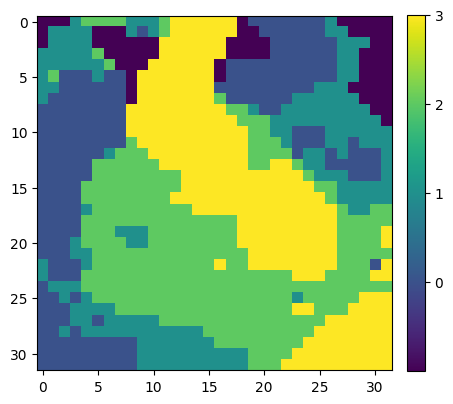

In [20]:
plt.imshow(binned_data.reshape((wideres,wideres)))
plt.gcf().set_size_inches(5,5)
plt.colorbar(ticks=[0,1,2,3,4], fraction=0.046, pad=0.04)
plt.show()

In [21]:
with open('../outputs/final_binned_data/wide_bins_std.pkl', 'wb') as f:
    pickle.dump(binned_data, f)

In [22]:
p_z_bhat_std = [np.sum(pzchat[idcs],axis=0)/len(idcs) for idcs in binned_wc]
trash_p_z_bhat_std = np.sum(pzchat[trash_bin_std]/len(trash_bin_std), axis=0)

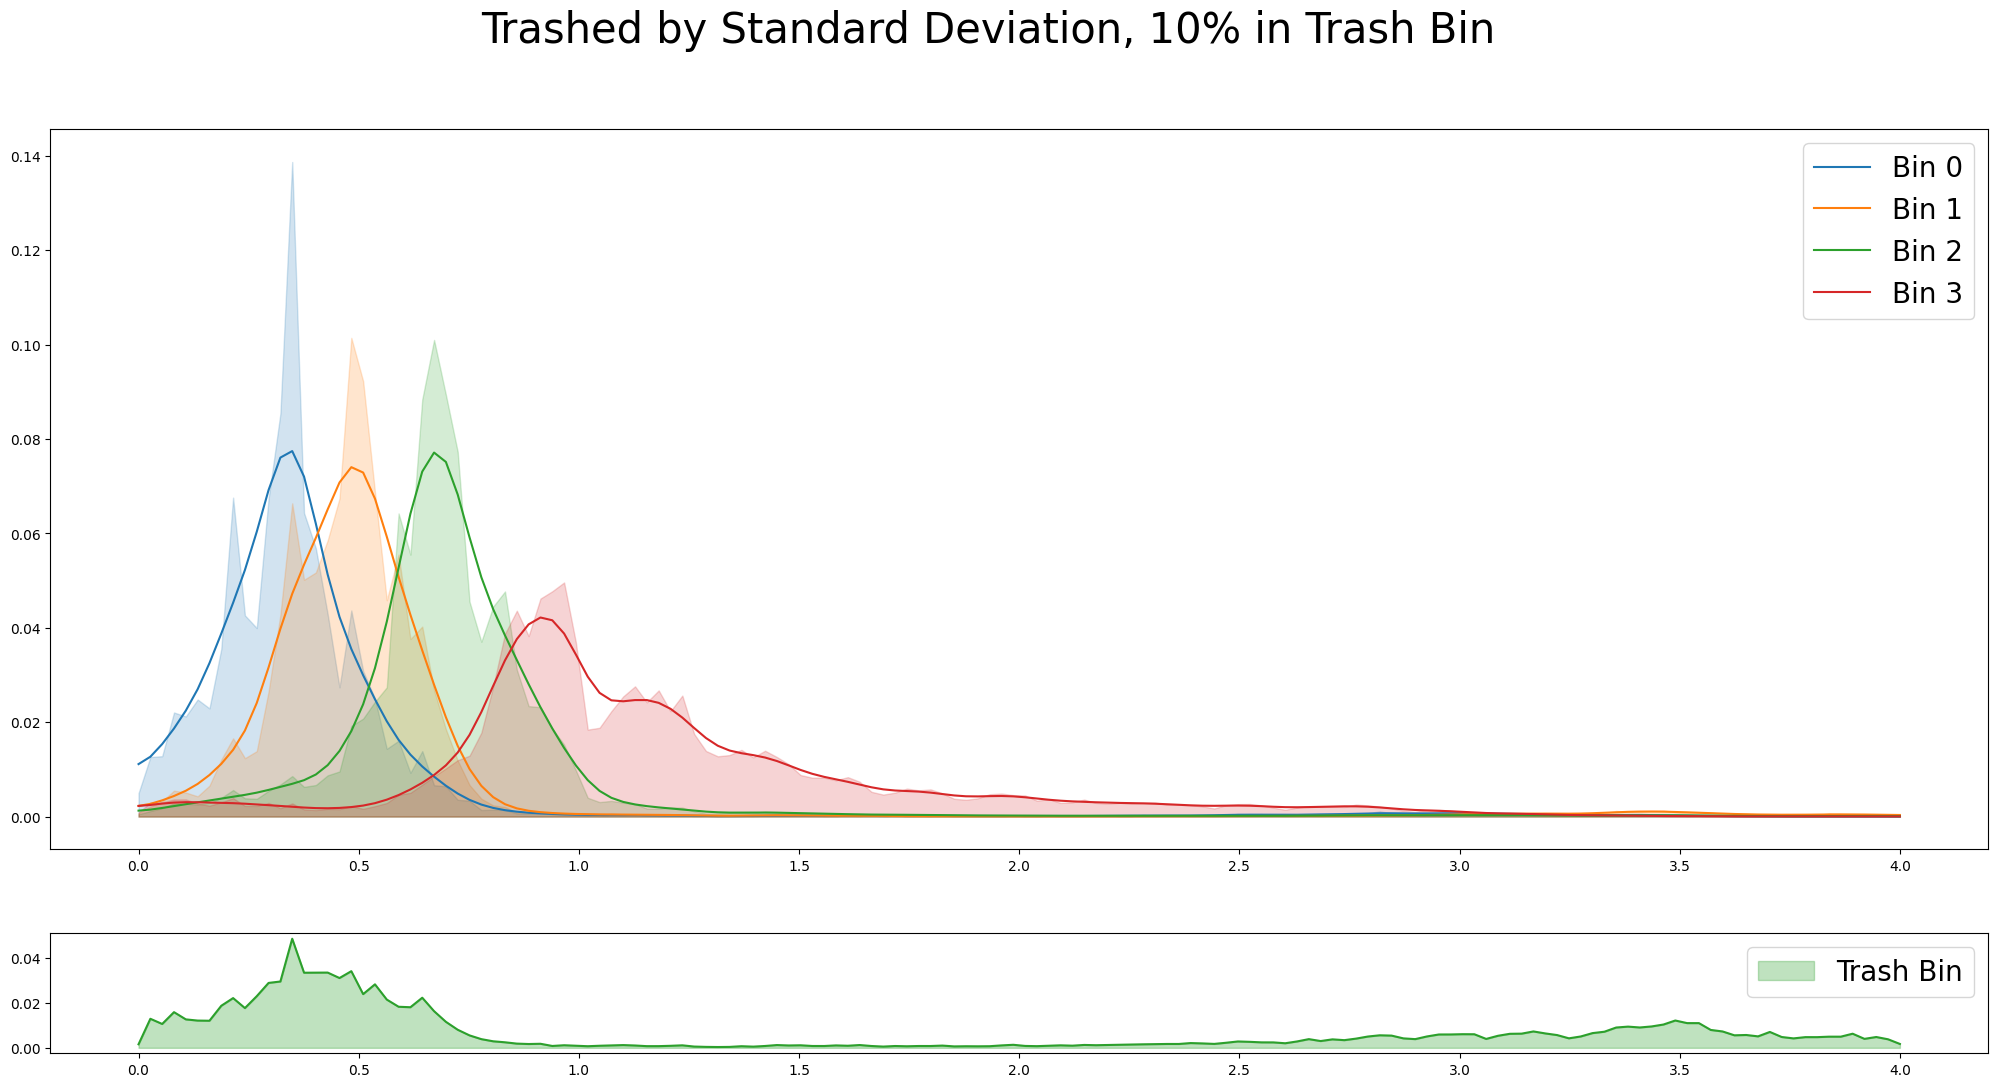

In [23]:
colors = [plt.cm.tab20(i*2) for i in range(5)]

fig, ax = plt.subplots(2, figsize=(25,12), height_ratios=[6,1])
r = (0,3)
for i,pz in enumerate(p_z_bhat_std):
    ax[0].plot(redshifts, gaussian_filter1d(pz, 2), color=colors[i], label="Bin %i"%i)
    ax[0].fill_between(redshifts, pz, alpha=0.2, color=colors[i])
    
    #av = np.average(t[mask]['Z']) ; mm = np.median(t[mask]['Z'])
    #ax[0].axvline(av, color=colors[i], label='bin average = %.02f'%av)
    #ax[0].axvline(mm, linestyle='-.', color=colors[i], label='bin median = %.02f'%mm)
    

ax[1].plot(redshifts, trash_p_z_bhat_std, color=colors[2])
ax[1].fill_between(redshifts, trash_p_z_bhat_std, color=colors[2], alpha=0.3, label='Trash Bin')
#av = np.average(t_rej['Z']) ; mm = np.median(t_rej['Z'])
#ax[1].axvline(av, color=colors[2], label='bin average = %.02f'%av)
#ax[1].axvline(mm, linestyle='-.', color=colors[2], label='bin median = %.02f'%mm)

'''
y3_means = [0.33, 0.52, 0.75, 0.94]
for a in ax:
    for m in y3_means:
        a.axvline(m, color='black')
'''

plt.suptitle("Trashed by Standard Deviation, 10% in Trash Bin", fontsize=30)
        
ax[0].legend(fontsize=20, loc='upper right')
ax[1].legend(fontsize=20)
plt.show()

### 5% trashed

In [24]:
# trash based on standard deviation
perc_in_trash = 0.05
ng_in_trash = 0 ; wc_in_trash = []
ordered_wc = [wc for _,wc in reversed(sorted(zip(std, range(wideres*wideres))))] 

i = 0
while ng_in_trash/ng < perc_in_trash:
    ng_in_trash += ngals_per_cell[ordered_wc[i]]
    i += 1
    
trash_bin_std_5pct = ordered_wc[:i]

In [25]:
print("~%.02f percent of cells in the trash bin"%(100*len(trash_bin_std_5pct)/(wideres*wideres)))
print('~%.02f percent of galaxes in trash bin'%(100*ng_in_trash/ng))

~1.86 percent of cells in the trash bin
~5.12 percent of galaxes in trash bin


In [26]:
nbins = 4
binned_wc = [[]] ; current_total = 0

ordered_meds = sorted(med)
ordered_wcs = [wc for _, wc in sorted(zip(med, range(wideres**2))) if wc not in trash_bin_std_5pct]
for m,wc in zip(ordered_meds,ordered_wcs):
    current_total += ngals_per_cell[wc]
    binned_wc[-1] += [wc]
    if current_total//((ng*(1-perc_in_trash))/nbins) == len(binned_wc):
        binned_wc += [[]]

In [27]:
binned_data = np.zeros(wideres**2)
binned_data[trash_bin_std_5pct] = -1
for i,mask in enumerate(binned_wc):
    binned_data[mask] = i

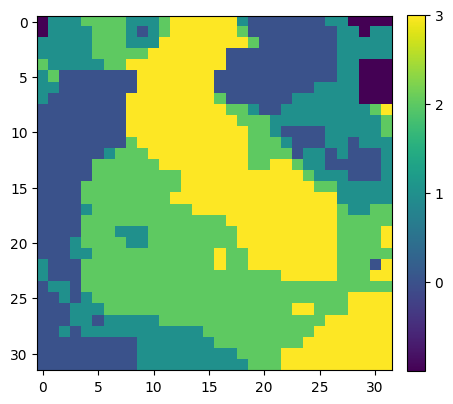

In [28]:
plt.imshow(binned_data.reshape((wideres,wideres)))
plt.gcf().set_size_inches(5,5)
plt.colorbar(ticks=[0,1,2,3,4], fraction=0.046, pad=0.04)
plt.show()

In [29]:
with open('../outputs/final_binned_data/wide_bins_std_5pct.pkl', 'wb') as f:
    pickle.dump(binned_data, f)

In [30]:
p_z_bhat_std_5pct = [np.sum(pzchat[idcs],axis=0)/len(idcs) for idcs in binned_wc]
trash_p_z_bhat_std_5pct = np.sum(pzchat[trash_bin_std]/len(trash_bin_std), axis=0)

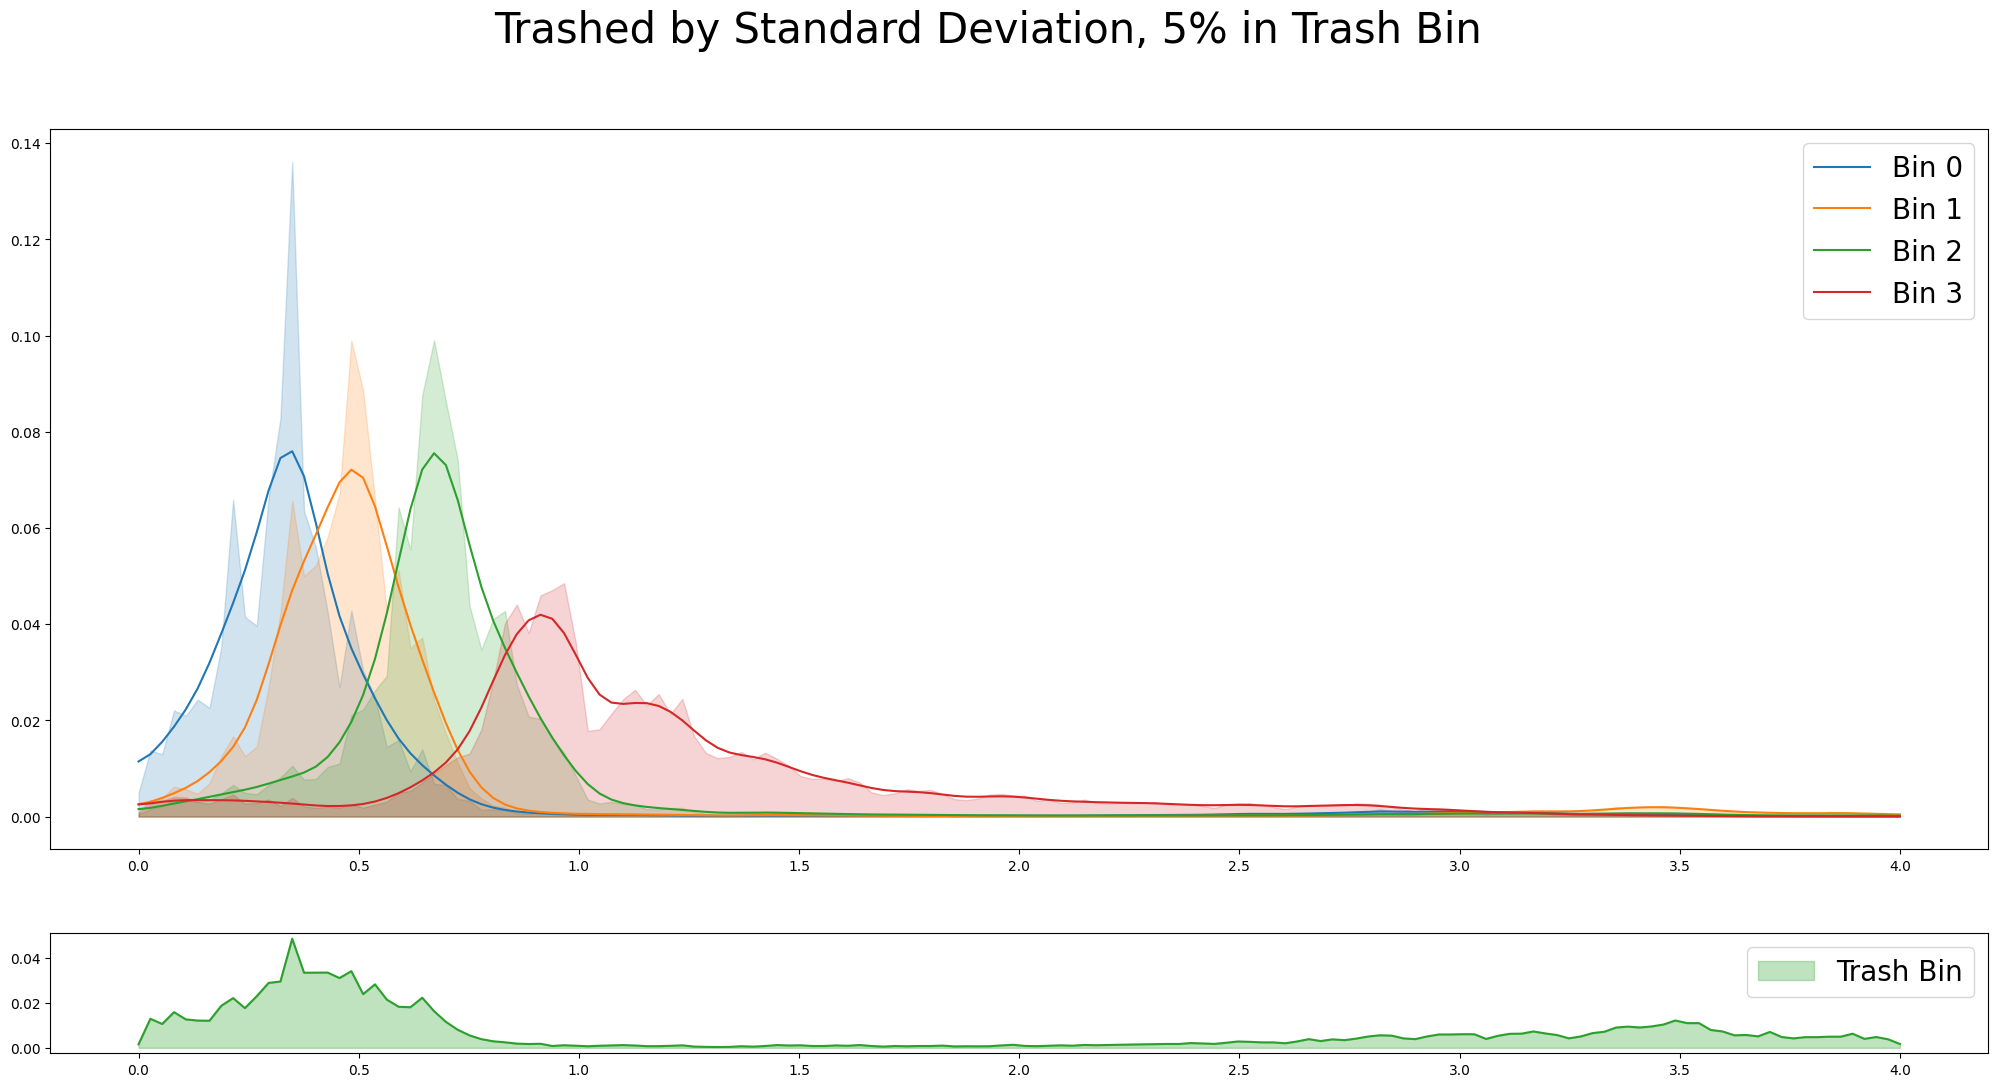

In [31]:
colors = [plt.cm.tab20(i*2) for i in range(5)]

fig, ax = plt.subplots(2, figsize=(25,12), height_ratios=[6,1])
r = (0,3)
for i,pz in enumerate(p_z_bhat_std_5pct):
    ax[0].plot(redshifts, gaussian_filter1d(pz, 2), color=colors[i], label="Bin %i"%i)
    ax[0].fill_between(redshifts, pz, alpha=0.2, color=colors[i])
    
    #av = np.average(t[mask]['Z']) ; mm = np.median(t[mask]['Z'])
    #ax[0].axvline(av, color=colors[i], label='bin average = %.02f'%av)
    #ax[0].axvline(mm, linestyle='-.', color=colors[i], label='bin median = %.02f'%mm)
    

ax[1].plot(redshifts, trash_p_z_bhat_std_5pct, color=colors[2])
ax[1].fill_between(redshifts, trash_p_z_bhat_std_5pct, color=colors[2], alpha=0.3, label='Trash Bin')
#av = np.average(t_rej['Z']) ; mm = np.median(t_rej['Z'])
#ax[1].axvline(av, color=colors[2], label='bin average = %.02f'%av)
#ax[1].axvline(mm, linestyle='-.', color=colors[2], label='bin median = %.02f'%mm)

'''
y3_means = [0.33, 0.52, 0.75, 0.94]
for a in ax:
    for m in y3_means:
        a.axvline(m, color='black')
'''

plt.suptitle("Trashed by Standard Deviation, 5% in Trash Bin", fontsize=30)
        
ax[0].legend(fontsize=20, loc='upper right')
ax[1].legend(fontsize=20)
plt.show()

# Trashed by Adjusted Standard Deviation

In [24]:
std_adj = std/(1+med)

In [26]:
# trash based on standard deviation

ng_in_trash = 0 ; wc_in_trash = []
ordered_wc = [wc for _,wc in reversed(sorted(zip(std_adj, range(wideres*wideres))))] 

i = 0
while ng_in_trash/ng < 0.1:
    ng_in_trash += ngals_per_cell[ordered_wc[i]]
    i += 1
    
trash_bin_std_adj = ordered_wc[:i]

In [27]:
"~%.00f percent of cells in the trash bin"%(100*len(trash_bin_std_adj)/(wideres*wideres))

'~8 percent of cells in the trash bin'

In [31]:
nbins = 4
binned_wc = [[]] ; current_total = 0

ordered_meds = sorted(med)
ordered_wcs = [wc for _, wc in sorted(zip(med, range(wideres**2))) if wc not in trash_bin_std_adj]
for m,wc in zip(ordered_meds,ordered_wcs):
    current_total += ngals_per_cell[wc]
    binned_wc[-1] += [wc]
    if current_total//(ng/nbins) == len(binned_wc):
        binned_wc += [[]]

In [32]:
binned_data = np.zeros(wideres**2)
binned_data[trash_bin_std_adj] = -1
for i,mask in enumerate(binned_wc):
    binned_data[mask] = i

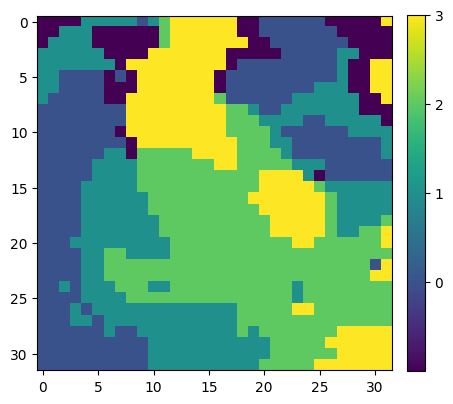

In [33]:
plt.imshow(binned_data.reshape((wideres,wideres)))
plt.gcf().set_size_inches(5,5)
plt.colorbar(ticks=[0,1,2,3,4], fraction=0.046, pad=0.04)
plt.show()

In [34]:
with open('../outputs/final_binned_data/wide_bins_std_adj.pkl', 'wb') as f:
    pickle.dump(binned_data, f)

In [35]:
p_z_bhat_std_adj = [np.sum(pzchat[idcs],axis=0)/len(idcs) for idcs in binned_wc]
trash_p_z_bhat_std_adj = np.sum(pzchat[trash_bin_std_adj]/len(trash_bin_std_adj), axis=0)

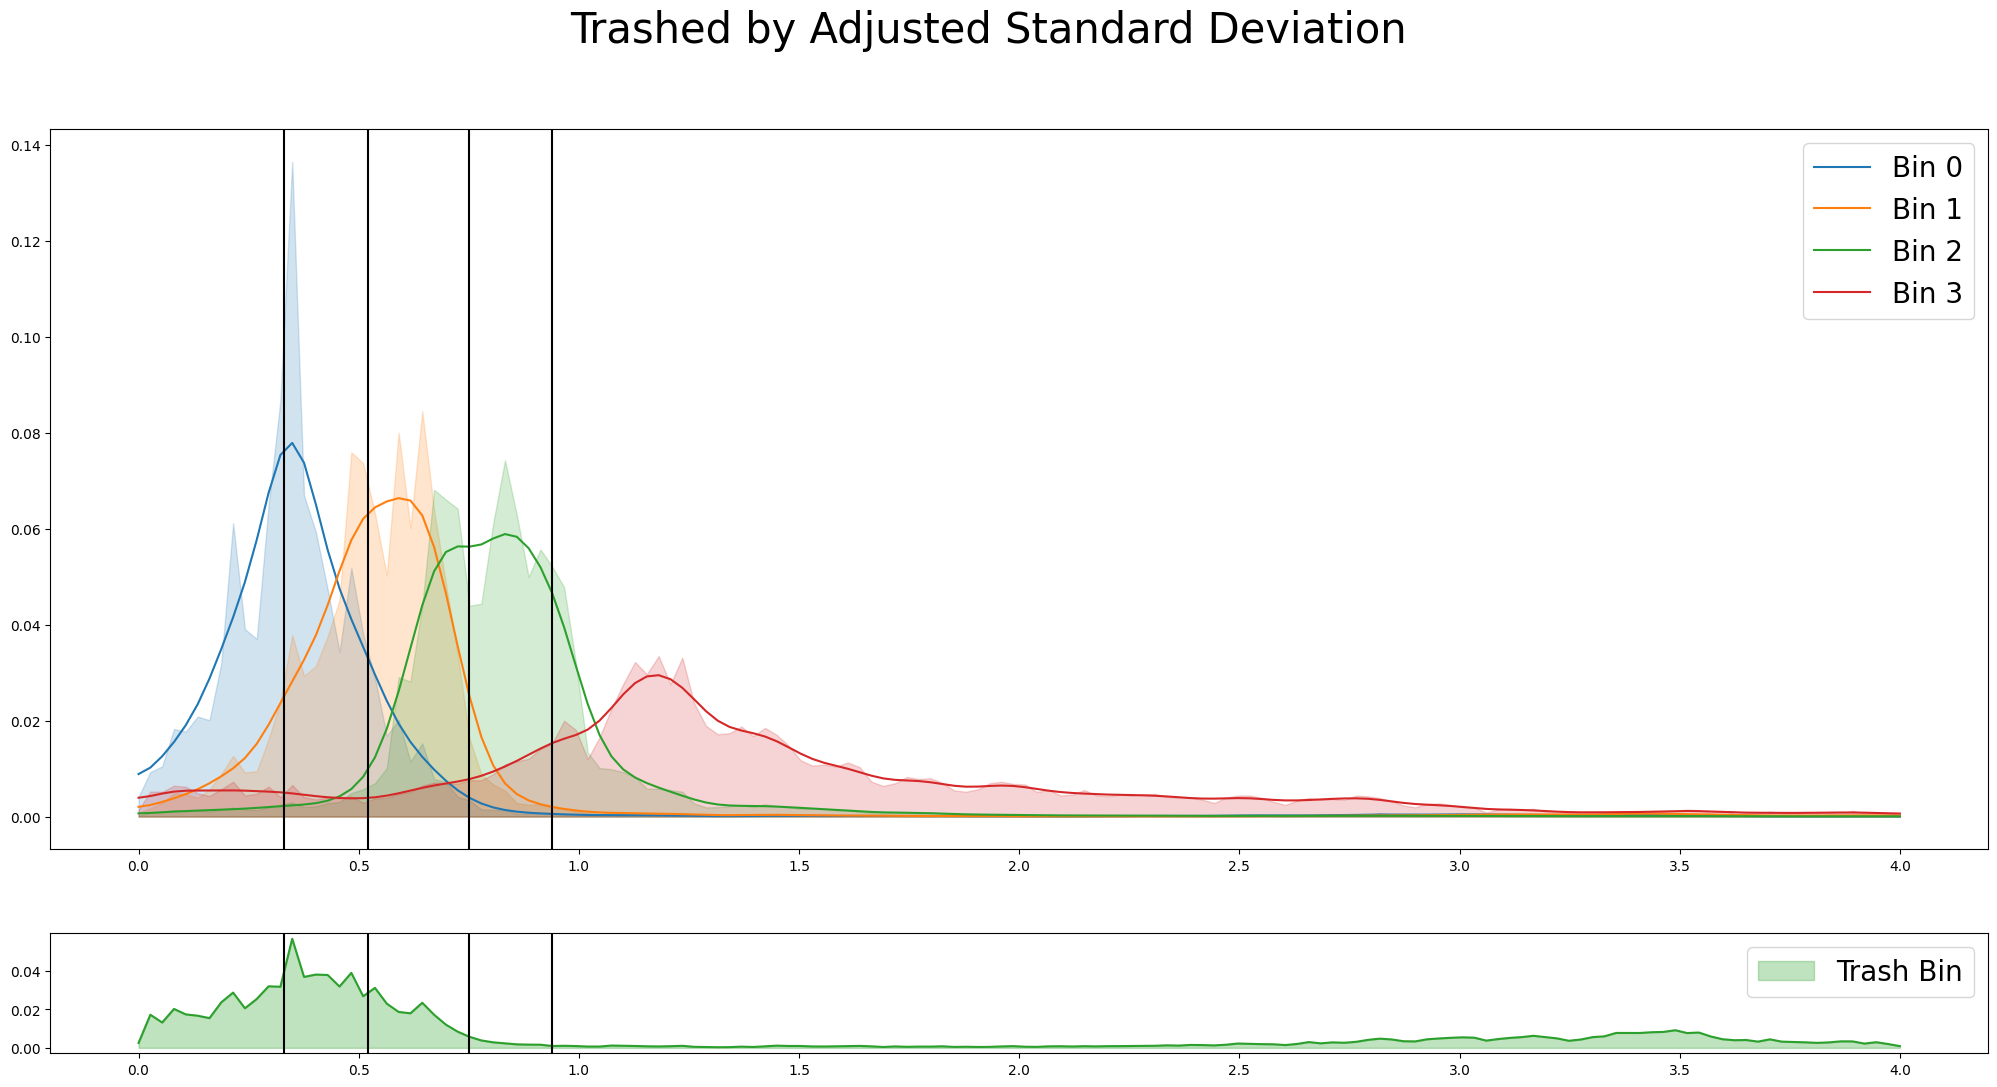

In [36]:
colors = [plt.cm.tab20(i*2) for i in range(5)]

fig, ax = plt.subplots(2, figsize=(25,12), height_ratios=[6,1])
r = (0,3)
for i,pz in enumerate(p_z_bhat_std_adj):
    ax[0].plot(redshifts, gaussian_filter1d(pz, 2), color=colors[i], label="Bin %i"%i)
    ax[0].fill_between(redshifts, pz, alpha=0.2, color=colors[i])
    
    #av = np.average(t[mask]['Z']) ; mm = np.median(t[mask]['Z'])
    #ax[0].axvline(av, color=colors[i], label='bin average = %.02f'%av)
    #ax[0].axvline(mm, linestyle='-.', color=colors[i], label='bin median = %.02f'%mm)
    

ax[1].plot(redshifts, trash_p_z_bhat_std_adj, color=colors[2])
ax[1].fill_between(redshifts, trash_p_z_bhat_std_adj, color=colors[2], alpha=0.3, label='Trash Bin')
#av = np.average(t_rej['Z']) ; mm = np.median(t_rej['Z'])
#ax[1].axvline(av, color=colors[2], label='bin average = %.02f'%av)
#ax[1].axvline(mm, linestyle='-.', color=colors[2], label='bin median = %.02f'%mm)

y3_means = [0.33, 0.52, 0.75, 0.94]
for a in ax:
    for m in y3_means:
        a.axvline(m, color='black')

plt.suptitle("Trashed by Adjusted Standard Deviation", fontsize=30)
        
ax[0].legend(fontsize=20, loc='upper right')
ax[1].legend(fontsize=20)
plt.show()

# Trashed by Log Adjusted Standard Deviation

In [37]:
std_adj_log = std/(1+med)

In [40]:
# trash based on standard deviation

ng_in_trash = 0 ; wc_in_trash = []
ordered_wc = [wc for _,wc in reversed(sorted(zip(std_adj_log, range(wideres*wideres))))] 

i = 0
while ng_in_trash/ng < 0.1:
    ng_in_trash += ngals_per_cell[ordered_wc[i]]
    i += 1
    
trash_bin_std_adj_log = ordered_wc[:i]

In [41]:
"~%.00f percent of cells in the trash bin"%(100*len(trash_bin_std_adj_log)/(wideres*wideres))

'~8 percent of cells in the trash bin'

In [43]:
nbins = 4
binned_wc = [[]] ; current_total = 0

ordered_meds = sorted(med)
ordered_wcs = [wc for _, wc in sorted(zip(med, range(wideres**2))) if wc not in trash_bin_std_adj_log]
for m,wc in zip(ordered_meds,ordered_wcs):
    current_total += ngals_per_cell[wc]
    binned_wc[-1] += [wc]
    if current_total//(ng/nbins) == len(binned_wc):
        binned_wc += [[]]

In [44]:
binned_data = np.zeros(wideres**2)
binned_data[trash_bin_std_adj_log] = -1
for i,mask in enumerate(binned_wc):
    binned_data[mask] = i

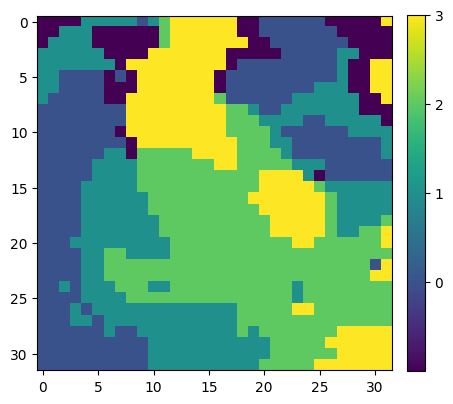

In [45]:
plt.imshow(binned_data.reshape((wideres,wideres)))
plt.gcf().set_size_inches(5,5)
plt.colorbar(ticks=[0,1,2,3,4], fraction=0.046, pad=0.04)
plt.show()

In [46]:
with open('../outputs/final_binned_data/wide_bins_std_adj_log.pkl', 'wb') as f:
    pickle.dump(binned_data, f)

In [47]:
p_z_bhat_std_adj_log = [np.sum(pzchat[idcs],axis=0)/len(idcs) for idcs in binned_wc]
trash_p_z_bhat_std_adj_log = np.sum(pzchat[trash_bin_std_adj_log]/len(trash_bin_std_adj_log), axis=0)

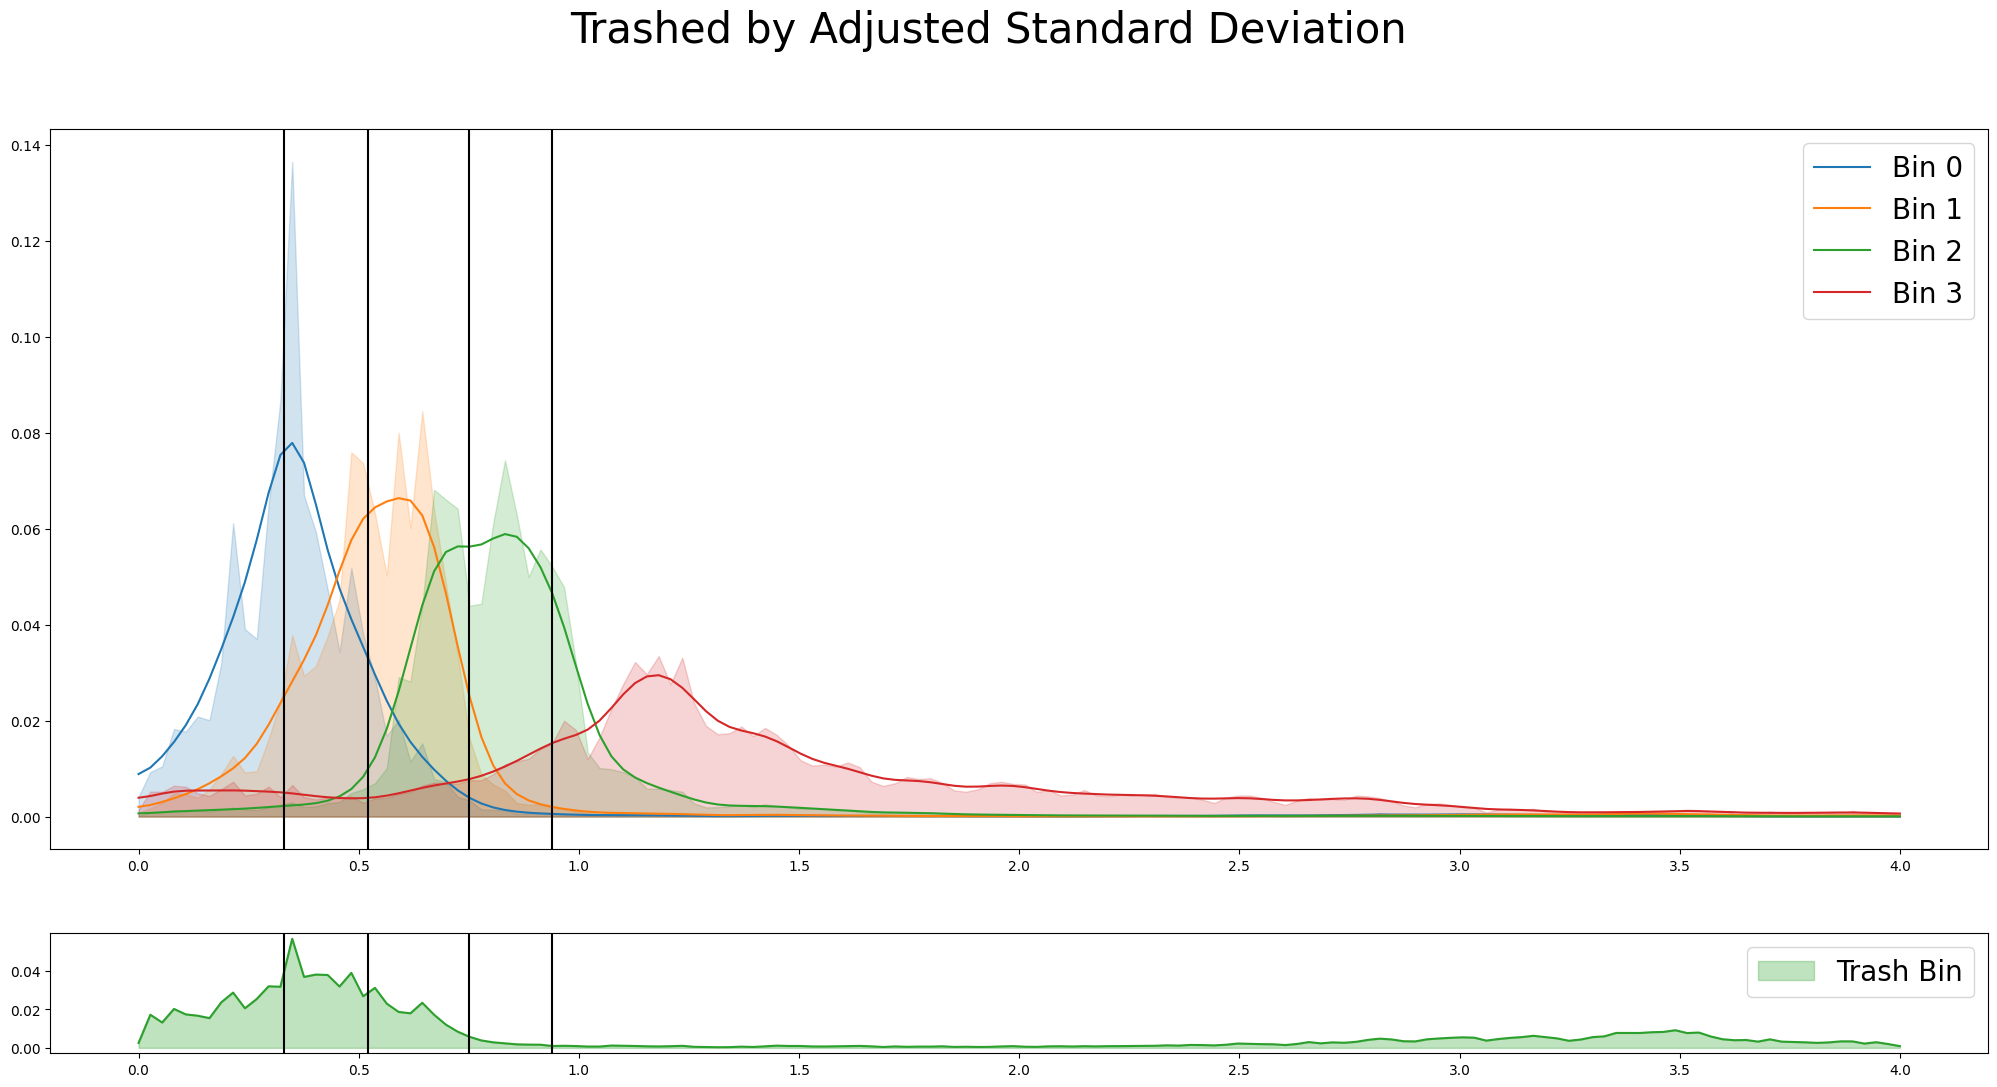

In [48]:
colors = [plt.cm.tab20(i*2) for i in range(5)]

fig, ax = plt.subplots(2, figsize=(25,12), height_ratios=[6,1])
r = (0,3)
for i,pz in enumerate(p_z_bhat_std_adj_log):
    ax[0].plot(redshifts, gaussian_filter1d(pz, 2), color=colors[i], label="Bin %i"%i)
    ax[0].fill_between(redshifts, pz, alpha=0.2, color=colors[i])
    
    #av = np.average(t[mask]['Z']) ; mm = np.median(t[mask]['Z'])
    #ax[0].axvline(av, color=colors[i], label='bin average = %.02f'%av)
    #ax[0].axvline(mm, linestyle='-.', color=colors[i], label='bin median = %.02f'%mm)
    

ax[1].plot(redshifts, trash_p_z_bhat_std_adj_log, color=colors[2])
ax[1].fill_between(redshifts, trash_p_z_bhat_std_adj_log, color=colors[2], alpha=0.3, label='Trash Bin')
#av = np.average(t_rej['Z']) ; mm = np.median(t_rej['Z'])
#ax[1].axvline(av, color=colors[2], label='bin average = %.02f'%av)
#ax[1].axvline(mm, linestyle='-.', color=colors[2], label='bin median = %.02f'%mm)

y3_means = [0.33, 0.52, 0.75, 0.94]
for a in ax:
    for m in y3_means:
        a.axvline(m, color='black')

plt.suptitle("Trashed by Adjusted Standard Deviation", fontsize=30)
        
ax[0].legend(fontsize=20, loc='upper right')
ax[1].legend(fontsize=20)
plt.show()

# Trashed by Concentration

In [49]:
boundary_z = 1.5
concentrations = concentration(boundary_z, pzchat)

In [50]:
# trash based on standard deviation

ng_in_trash = 0 ; wc_in_trash = []
ordered_wc = [wc for _,wc in reversed(sorted(zip(concentrations, range(wideres*wideres))))] 

i = 0
while ng_in_trash/ng < 0.1:
    ng_in_trash += ngals_per_cell[ordered_wc[i]]
    i += 1
    
trash_bin_con = ordered_wc[:i]

In [51]:
"~%.00f percent of cells in the trash bin"%(100*len(trash_bin_con)/(wideres*wideres))

'~11 percent of cells in the trash bin'

In [52]:
nbins = 4
binned_wc = [[]] ; current_total = 0

ordered_meds = sorted(med)
ordered_wcs = [wc for _, wc in sorted(zip(med, range(wideres**2))) if wc not in trash_bin_con]
for m,wc in zip(ordered_meds,ordered_wcs):
    current_total += ngals_per_cell[wc]
    binned_wc[-1] += [wc]
    if current_total//(ng/nbins) == len(binned_wc):
        binned_wc += [[]]

In [53]:
binned_data = np.zeros(wideres**2)
binned_data[trash_bin_con] = -1
for i,mask in enumerate(binned_wc):
    binned_data[mask] = i

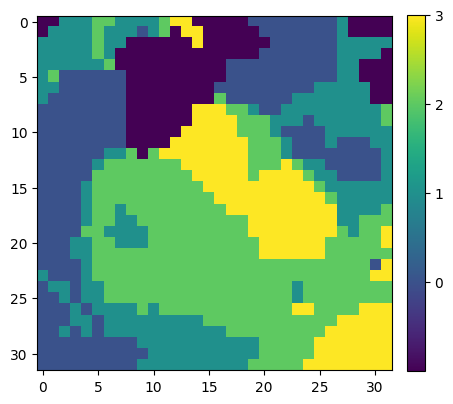

In [54]:
plt.imshow(binned_data.reshape((wideres,wideres)))
plt.gcf().set_size_inches(5,5)
plt.colorbar(ticks=[0,1,2,3,4], fraction=0.046, pad=0.04)
plt.show()

In [55]:
with open('../outputs/final_binned_data/wide_bins_con.pkl', 'wb') as f:
    pickle.dump(binned_data, f)

In [56]:
p_z_bhat_con = [np.sum(pzchat[idcs],axis=0)/len(idcs) for idcs in binned_wc]
trash_p_z_bhat_con = np.sum(pzchat[trash_bin_con]/len(trash_bin_con), axis=0)

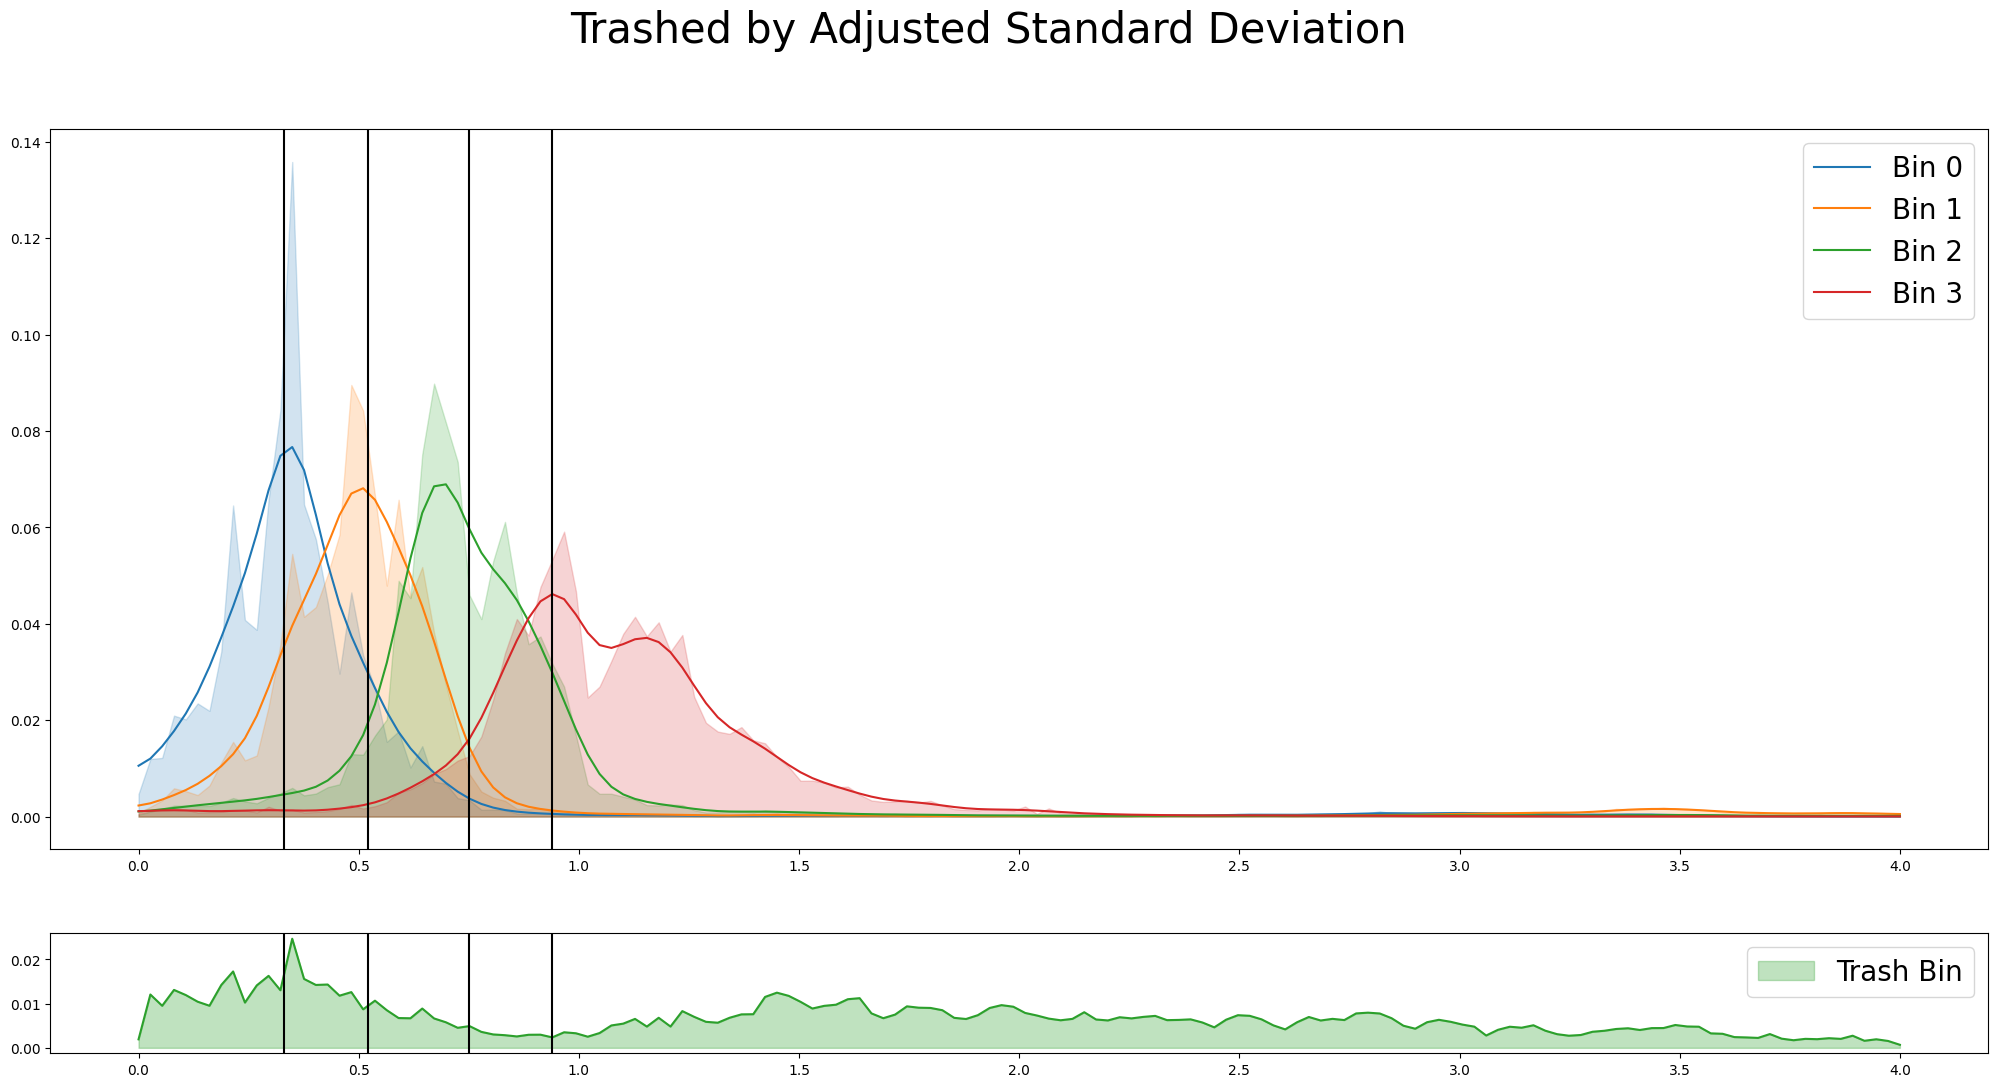

In [57]:
colors = [plt.cm.tab20(i*2) for i in range(5)]

fig, ax = plt.subplots(2, figsize=(25,12), height_ratios=[6,1])
r = (0,3)
for i,pz in enumerate(p_z_bhat_con):
    ax[0].plot(redshifts, gaussian_filter1d(pz, 2), color=colors[i], label="Bin %i"%i)
    ax[0].fill_between(redshifts, pz, alpha=0.2, color=colors[i])
    
    #av = np.average(t[mask]['Z']) ; mm = np.median(t[mask]['Z'])
    #ax[0].axvline(av, color=colors[i], label='bin average = %.02f'%av)
    #ax[0].axvline(mm, linestyle='-.', color=colors[i], label='bin median = %.02f'%mm)
    

ax[1].plot(redshifts, trash_p_z_bhat_con, color=colors[2])
ax[1].fill_between(redshifts, trash_p_z_bhat_con, color=colors[2], alpha=0.3, label='Trash Bin')
#av = np.average(t_rej['Z']) ; mm = np.median(t_rej['Z'])
#ax[1].axvline(av, color=colors[2], label='bin average = %.02f'%av)
#ax[1].axvline(mm, linestyle='-.', color=colors[2], label='bin median = %.02f'%mm)

y3_means = [0.33, 0.52, 0.75, 0.94]
for a in ax:
    for m in y3_means:
        a.axvline(m, color='black')

plt.suptitle("Trashed by Adjusted Standard Deviation", fontsize=30)
        
ax[0].legend(fontsize=20, loc='upper right')
ax[1].legend(fontsize=20)
plt.show()

# Comparison

In [32]:
pzbhats = {"Naïve": p_z_bhat,
            "10%": p_z_bhat_std,
            "5%": p_z_bhat_std_5pct,
            #"Adjusted Standard Deviation": p_z_bhat_std_adj,
            #"Log Adjusted Standard Deviation": p_z_bhat_std_adj_log,
            #"Concentration": p_z_bhat_con,
          }

trash_pzbhats = {
            "10%": trash_p_z_bhat_std,
            "5%": trash_p_z_bhat_std_5pct,
            #"Adjusted Standard Deviation": trash_p_z_bhat_std_adj,
            #"Log Adjusted Standard Deviation": trash_p_z_bhat_std_adj_log,
            #"Concentration": trash_p_z_bhat_con,
          }

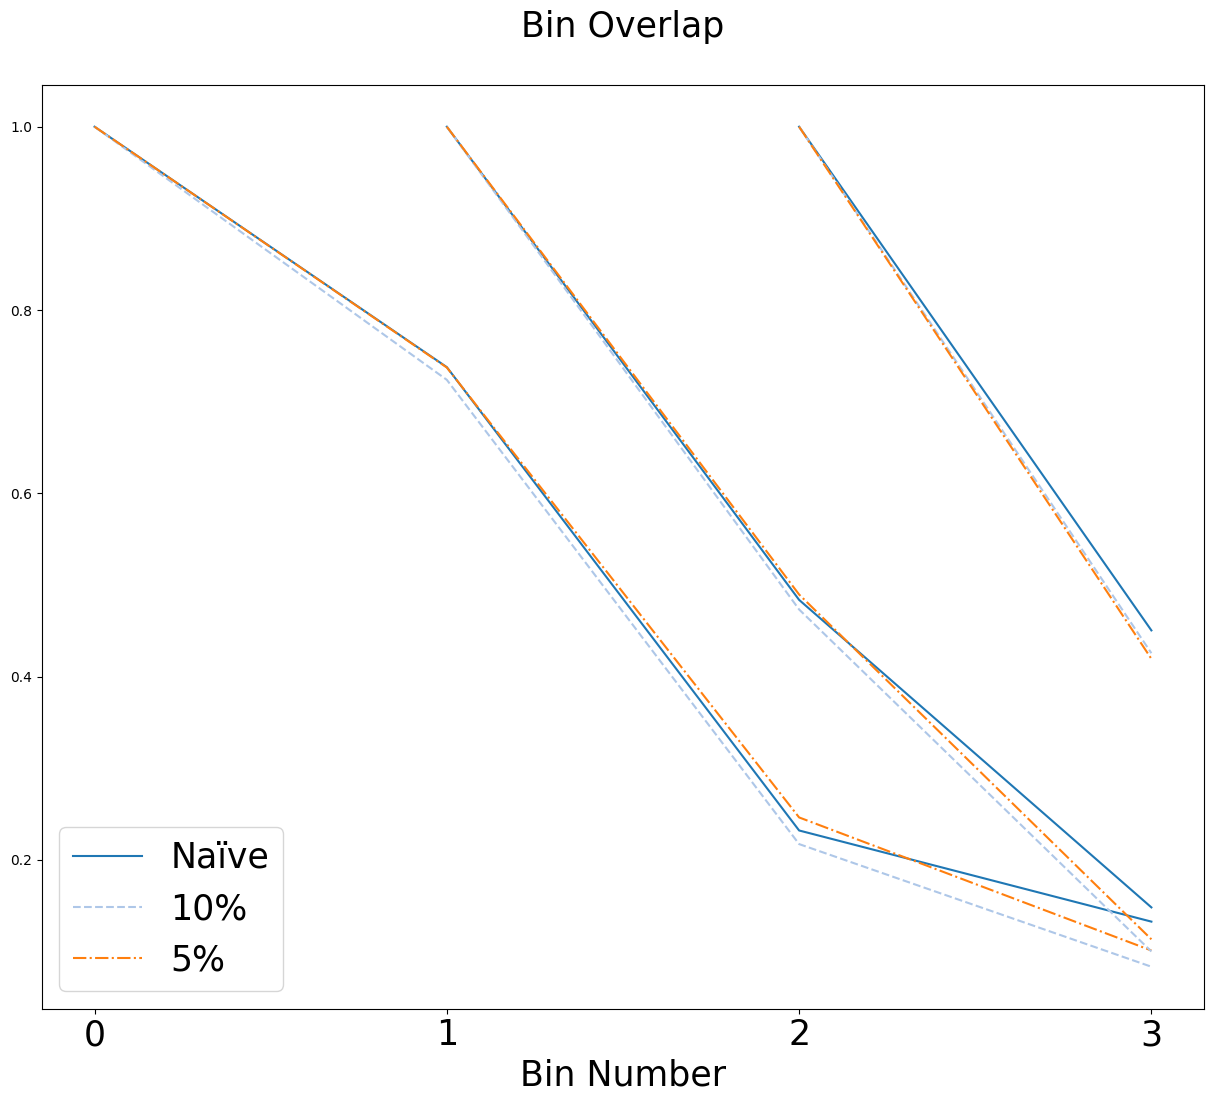

In [33]:
overlaps = {key: get_overlap(pzbhats[key]) for key in pzbhats}

cmap1 = mpl.cm.get_cmap('tab20')
markers = ['-', '--', '-.', ':']

for i in range(nbins):
    for j,bintype in enumerate(overlaps):
        if i == 0:
            plt.plot(range(i, 4), [overlaps[bintype][i][k] for k in range(i,4)], markers[j%len(markers)],
                     label=bintype, color=cmap1(j/20))
        else:
            plt.plot(range(i, 4), [overlaps[bintype][i][k] for k in range(i,4)], markers[j%len(markers)],
                     color=cmap1(j/20))
            
plt.xticks(range(nbins), fontsize=25)
plt.xlabel('Bin Number', fontsize=25)
plt.legend(fontsize=25)
plt.title('Bin Overlap\n', fontsize=25)
plt.gcf().set_size_inches(15,12)
plt.show()

In [34]:
# mean redshifts
def expectation_value(x, pdist):
    return np.sum(x*pdist)/np.sum(pdist)

def width(x, pdist):
    return np.sqrt(expectation_value(x**2, pdist) - expectation_value(x,pdist)**2)

means = {key: [expectation_value(redshifts, pd) for pd in pzbhats[key]] for key in pzbhats}
widths = {key: [width(redshifts, pd) for pd in pzbhats[key]] for key in pzbhats}

trash_means = {key: expectation_value(redshifts, trash_pzbhats[key]) for key in trash_pzbhats}
trash_widths = {key: width(redshifts, trash_pzbhats[key]) for key in trash_pzbhats}

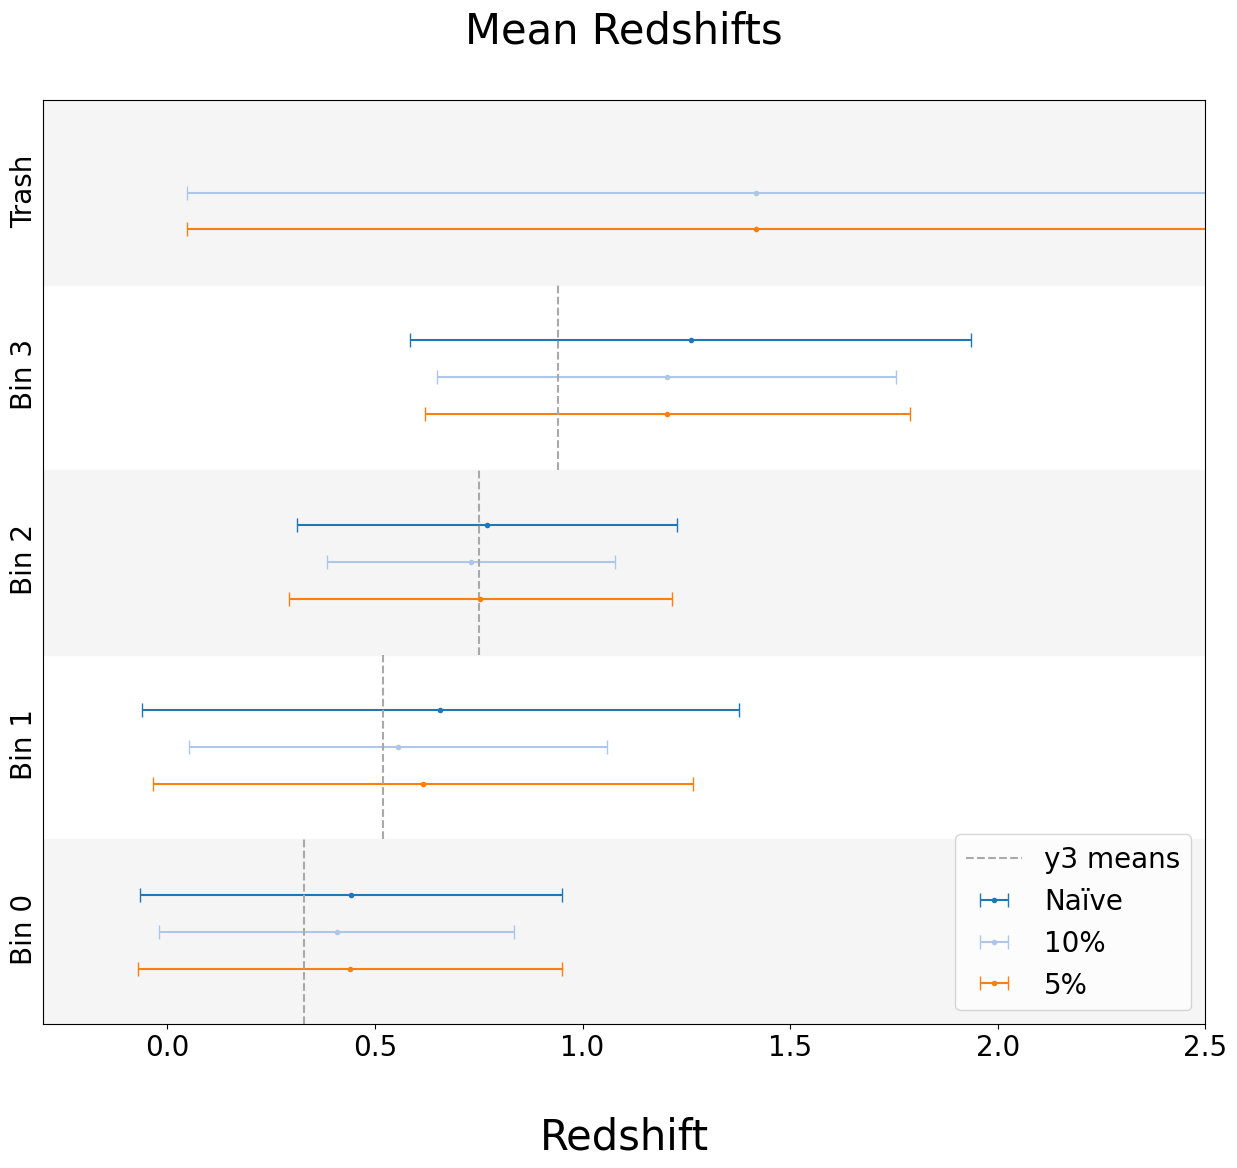

In [35]:
colors = [cmap1(j/20) for j in range(20)]
for binnum in range(nbins):
    bin_means = {key:means[key][binnum] for key in means}
    bin_widths = {key:widths[key][binnum] for key in widths}
    
    offsets = np.linspace(binnum+0.2,binnum-0.2, len(means))
    for i,key in enumerate(means):  
        if binnum == 0:
            plt.errorbar([bin_means[key]], [offsets[i]], fmt='.', 
                     xerr=[bin_widths[key]], capsize=5, label=key,
                     c = colors[i])
        else:
            plt.errorbar([bin_means[key]], [offsets[i]], fmt='.', 
                     xerr=[bin_widths[key]], capsize=5,
                     c = colors[i])
            
offsets = np.linspace(nbins+0.2, nbins-0.2, len(means))
for i, key in enumerate(means):
    if key == 'Naïve': continue
    plt.errorbar([trash_means[key]], [offsets[i]], fmt='.', 
                 xerr=[trash_widths[key]], capsize=5,
                 c = colors[i])
    
    
plt.xlim(-0.3,2.5)
plt.ylim(-0.5, 4.5)
plt.gcf().set_size_inches(15,12)
plt.xlabel('\nRedshift', fontsize=30)
plt.yticks([0.15,1.15,2.15,3.15, 4.15], labels=["Bin %i"%i for i in range(nbins)]+['Trash'], rotation=90, fontsize=20)
plt.xticks(fontsize=20)
plt.tick_params(axis='y', length=0)

for i in range(nbins+1):
    if i%2==0:
        plt.fill_between([-2,6],
                         [i+0.5, i+0.5], [i-0.5, i-0.5], 
                         color='whitesmoke')
        
y3_means = [0.33, 0.52, 0.75, 0.94]
for i,m in enumerate(y3_means):
    if i ==0:
        plt.plot([m,m], [i-0.5,i+0.5], linestyle='--', color='darkgray', label="y3 means")
    else:
        plt.plot([m,m], [i-0.5,i+0.5], linestyle='--', color='darkgray')

plt.legend(fontsize=20, loc='lower right')

plt.title("Mean Redshifts\n", fontsize=30)
plt.show()

$\sigma$

$\frac{\sigma}{1+z}$

$\frac{\sigma}{log_{10}(1+z)}$

$\int_{z_{cut}}^{\infty} P(z) dz$

# Binned By Concentration

In [ ]:
nbins = 4

num_in_trash = 0.1*ng
num_per_bin = 0.9*ng // nbins

In [ ]:
# throw out trash first
# trash based on redshift concentration

boundary_z = 1.5
concentrations = concentration(boundary_z, pzchat)

ng_in_trash = 0 ; wc_in_trash = []
ordered_wc = [wc for _,wc in reversed(sorted(zip(concentrations, range(wideres*wideres))))] 

i = 0
while ng_in_trash/ng < 0.1:
    ng_in_trash += get_cell_len(ordered_wc[i])
    i += 1
    
trash_bin = ordered_wc[:i]

In [ ]:
conc_centers = [0.1,0.5,0.9,1.3] ; width = 0.1
bins = {str(i): np.array([], dtype=int) for i in range(nbins)}

available_cells = np.array([wc for wc in range(wideres**2) if wc not in trash_bin])
for (i,b), cc in zip(enumerate(bins), conc_centers):
    b_conc = concentration_range(cc, width, pzchat[available_cells])
    
    btot = 0
    for _, wc, wcl in sorted(zip(b_conc, available_cells, ngals_per_cell[available_cells])):
        bins[b] = np.append(bins[b],[int(wc)])
        btot += wcl
        if btot > num_per_bin: break
        
    available_cells = [c for c in available_cells if c not in bins[b]]
    
p_z_bhat_range = [np.sum(pzchat[bins[b]], axis=0)/len(bins[b]) for b in list('0123')]
p_z_bhat_trash_range = np.sum(pzchat[trash_bin]/len(trash_bin), axis=0)

In [ ]:
colors = [plt.cm.tab20(i*2) for i in range(5)]

fig, ax = plt.subplots(2, figsize=(25,12), height_ratios=[6,1])
r = (0,3)
for i,pz in enumerate(p_z_bhat_range):
    ax[0].plot(redshifts, gaussian_filter1d(pz, 2), color=colors[i], label="Bin %i"%i)
    ax[0].fill_between(redshifts, pz, alpha=0.2, color=colors[i])
    
    #av = np.average(t[mask]['Z']) ; mm = np.median(t[mask]['Z'])
    #ax[0].axvline(av, color=colors[i], label='bin average = %.02f'%av)
    #ax[0].axvline(mm, linestyle='-.', color=colors[i], label='bin median = %.02f'%mm)
    

ax[1].plot(redshifts, p_z_bhat_trash_range, color=colors[2])
ax[1].fill_between(redshifts, p_z_bhat_trash_range, color=colors[2], alpha=0.3, label='Trash Bin')
#av = np.average(t_rej['Z']) ; mm = np.median(t_rej['Z'])
#ax[1].axvline(av, color=colors[2], label='bin average = %.02f'%av)
#ax[1].axvline(mm, linestyle='-.', color=colors[2], label='bin median = %.02f'%mm)

y3_means = [0.33, 0.52, 0.75, 0.94]
for a in ax:
    for m in y3_means:
        a.axvline(m, color='black')

plt.suptitle(r"Binned by Concentration", fontsize=30)
        
ax[0].legend(fontsize=20, loc='upper right')
ax[1].legend(fontsize=20)
plt.show()

In [ ]:
con = get_overlap(p_z_bhat_range) 

cmap1 = mpl.cm.get_cmap('tab20c')
cmap2 = mpl.cm.get_cmap('tab20c')

for i in range(4):
    plt.plot(range(i, 4), [con[i,j] for j in range(i,4)], '--', 
             label='Bin %i'%i, color=cmap1(i/4))

plt.xticks(range(nbins), fontsize=25)
plt.xlabel('Bin Number', fontsize=25)
plt.legend(fontsize=25)
plt.title('Bin Overlap, Binned by Median\n', fontsize=25)
plt.gcf().set_size_inches(25,14)
plt.show()